In [2]:
#from google.colab import drive
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

In [3]:
# drive.mount('/content/gdrive/')
# dir_path = '/content/gdrive/MyDrive/Colab_Notebooks/MLWBD_Project/'
# sys.path.append(dir_path)

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
start_time = time.time()
complaints_cfpb = pd. DataFrame()

for chunk in pd.read_csv('complaints.csv', chunksize=400000):
    print('Number of chunks read: ', chunk.shape)
    complaints_cfpb = pd.concat([complaints_cfpb, chunk])

print("Time taken to read the data: ", time.time() - start_time)

print("Shape of the dataframe: ", complaints_cfpb.shape)

Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (400000, 18)
Number of chunks read:  (335939, 18)
Time taken to read the data:  36.277591943740845
Shape of the dataframe:  (6335939, 18)


In [6]:
complaints_cfpb.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2024-07-27,Credit card,General-purpose credit card or charge card,Getting a credit card,Card opened without my consent or knowledge,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,CA,94519,NaN,Consent not provided,Web,2024-07-27,Closed with non-monetary relief,Yes,NaN,9634839
1,2024-09-18,Credit reporting or other personal consumer re...,Other personal consumer report,Incorrect information on your report,Information belongs to someone else,NaN,NaN,ENCORE CAPITAL GROUP INC.,FL,34472,NaN,NaN,Web,2024-09-18,Closed with explanation,Yes,NaN,10169554
2,2024-09-19,Student loan,Private student loan,Struggling to repay your loan,Bankruptcy,NaN,NaN,CL Holdings LLC,KY,40160,NaN,NaN,Web,2024-09-19,In progress,Yes,NaN,10169752
3,2024-06-09,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,I recently reviewed a copy of my credit report...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,91730,NaN,Consent provided,Web,2024-06-09,Closed with non-monetary relief,Yes,NaN,9213312
4,2024-07-24,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,"To Whom It May Concern, I am writing in respon...",NaN,TrueAccord Corp.,TX,761XX,NaN,Consent provided,Web,2024-07-24,Closed with explanation,Yes,NaN,9592293


In [7]:
complaints_cfpb.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335939 entries, 0 to 6335938
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 8.3 

In [8]:
complaints_cfpb['Date received'] = pd.to_datetime(complaints_cfpb['Date received'], errors='coerce')
complaints_cfpb['Date sent to company'] = pd.to_datetime(complaints_cfpb['Date sent to company'], errors='coerce')

In [9]:
for col in complaints_cfpb.select_dtypes(include='object').columns:
    complaints_cfpb[col] = complaints_cfpb[col].astype('category')

In [10]:
def check_col_null_distribution(df):
    total_rows = df.shape[0]
    columns_with_null = df.columns[df.isnull().any()]

    null_percentages = {}

    for col in columns_with_null:
        null_count = df[col].isnull().sum()
        null_percentage = (null_count / total_rows) * 100
        null_percentages[col] = null_percentage

    return null_percentages

In [11]:
def plot_null_percentage(df):
    null_percentages = check_col_null_distribution(df)

    columns_with_null = list(null_percentages.keys())
    percentages = list(null_percentages.values())

    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=columns_with_null, y=percentages, palette='viridis')

    plt.xticks(rotation=90)

    for i, p in enumerate(ax.patches):
        ax.annotate(f'{percentages[i]:.2f}%',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10)

    plt.ylabel('Percentage of missing values')
    plt.xlabel('Columns')
    plt.title('Percentage of missing values in each column')
    plt.show()

/var/folders/gn/2snxnw0d43nbcsdsz8xvy5cr0000gn/T/ipykernel_98930/293090321.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=columns_with_null, y=percentages, palette='viridis')


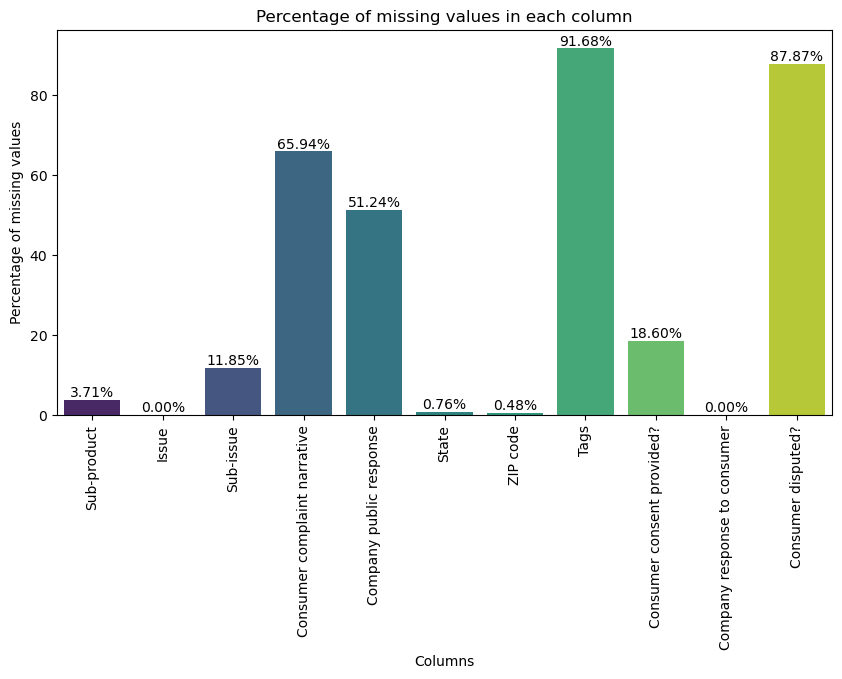

In [12]:
plot_null_percentage(complaints_cfpb)

In [13]:
columns_to_retain = ['Product', 'Issue', 'Company response to consumer', 'Sub-product', 'Sub-issue', 'State', 'ZIP code']

columns_to_drop = ['Tags', 'Consumer disputed?', 'Consumer consent provided?', 'Consumer complaint narrative']

In [14]:
complaints_cfpb.drop(columns=columns_to_drop, axis=1, inplace=True)

In [15]:
complaints_cfpb['Sub-product'] = complaints_cfpb['Sub-product'].cat.add_categories("None").fillna("None")
complaints_cfpb['Sub-issue'] = complaints_cfpb['Sub-issue'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company response to consumer'] = complaints_cfpb['Company response to consumer'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['Company public response'] = complaints_cfpb['Company public response'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['State'] = complaints_cfpb['State'].cat.add_categories("Unknown").fillna("Unknown")
complaints_cfpb['ZIP code'] = complaints_cfpb['ZIP code'].cat.add_categories("Not Provided").fillna("Not Provided")

In [16]:
complaints_cfpb.shape

(6335939, 14)

In [17]:
complaints_cfpb.isnull().sum()

Date received                   0
Product                         0
Sub-product                     0
Issue                           6
Sub-issue                       0
Company public response         0
Company                         0
State                           0
ZIP code                        0
Submitted via                   0
Date sent to company            0
Company response to consumer    0
Timely response?                0
Complaint ID                    0
dtype: int64

In [18]:
# See the range of dates in the dataset
print("Minimum date in the dataset: ", complaints_cfpb['Date received'].min())
print("Maximum date in the dataset: ", complaints_cfpb['Date received'].max())

Minimum date in the dataset:  2011-12-01 00:00:00
Maximum date in the dataset:  2024-10-06 00:00:00


In [19]:
# Subset the data ro include only the data after 01/01/2020
complaints_cfpb = complaints_cfpb[complaints_cfpb['Date received'] >= '2023-01-01']

In [20]:
categorical_cols = ['Product', 'Sub-product', 'Issue', 'Sub-issue', 'State', 'Submitted via']
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
encoded_data = encoder.fit_transform(complaints_cfpb[categorical_cols])

encoded_df = pd.DataFrame.sparse.from_spmatrix(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df.index = complaints_cfpb.index

complaints_cfpb = pd.concat([complaints_cfpb.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [21]:
complaints_cfpb.shape

(3121960, 455)

In [22]:
complaints_cfpb.head()

,Date received,Company public response,Company,ZIP code,Date sent to company,Company response to consumer,Timely response?,Complaint ID,Product_Checking or savings account,Product_Credit card,...,State_WA,State_WI,State_WV,State_WY,Submitted via_Email,Submitted via_Phone,Submitted via_Postal mail,Submitted via_Referral,Submitted via_Web,Submitted via_Web Referral
0,2024-07-27,Unknown,CAPITAL ONE FINANCIAL CORPORATION,94519,2024-07-27,Closed with non-monetary relief,Yes,9634839,0,1.00,...,0,0,0,0,0,0,0,0,1.00,0
1,2024-09-18,Unknown,ENCORE CAPITAL GROUP INC.,34472,2024-09-18,Closed with explanation,Yes,10169554,0,0,...,0,0,0,0,0,0,0,0,1.00,0
2,2024-09-19,Unknown,CL Holdings LLC,40160,2024-09-19,In progress,Yes,10169752,0,0,...,0,0,0,0,0,0,0,0,1.00,0
3,2024-06-09,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,91730,2024-06-09,Closed with non-monetary relief,Yes,9213312,0,0,...,0,0,0,0,0,0,0,0,1.00,0
4,2024-07-24,Unknown,TrueAccord Corp.,761XX,2024-07-24,Closed with explanation,Yes,9592293,0,0,...,0,0,0,0,0,0,0,0,1.00,0


In [23]:
complaints_cfpb["Company response to consumer"].value_counts()

Company response to consumer
Closed with explanation            1391296
Closed with non-monetary relief    1310424
In progress                         380908
Closed with monetary relief          36265
Untimely response                     3049
Unknown                                 18
Closed                                   0
Closed with relief                       0
Closed without relief                    0
Name: count, dtype: int64

In [24]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the "Company response to consumer" column
complaints_cfpb["Company response to consumer_encoded"] = le.fit_transform(complaints_cfpb["Company response to consumer"])

# Print the mapping
for i, category in enumerate(le.classes_):
    print(f"{category}: {i}")

# Check the value counts of the encoded column
print(complaints_cfpb["Company response to consumer_encoded"].value_counts())

Closed with explanation: 0
Closed with monetary relief: 1
Closed with non-monetary relief: 2
In progress: 3
Unknown: 4
Untimely response: 5
Company response to consumer_encoded
0    1391296
2    1310424
3     380908
1      36265
5       3049
4         18
Name: count, dtype: int64


In [25]:
complaints_cfpb.columns

Index(['Date received', 'Company public response', 'Company', 'ZIP code',
       'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Complaint ID',
       'Product_Checking or savings account', 'Product_Credit card',
       ...
       'State_WI', 'State_WV', 'State_WY', 'Submitted via_Email',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral', 'Company response to consumer_encoded'],
      dtype='object', length=456)

In [26]:
complaints_cfpb.drop('Complaint ID', axis=1)

,Date received,Company public response,Company,ZIP code,Date sent to company,Company response to consumer,Timely response?,Product_Checking or savings account,Product_Credit card,Product_Credit card or prepaid card,...,State_WI,State_WV,State_WY,Submitted via_Email,Submitted via_Phone,Submitted via_Postal mail,Submitted via_Referral,Submitted via_Web,Submitted via_Web Referral,Company response to consumer_encoded
0,2024-07-27,Unknown,CAPITAL ONE FINANCIAL CORPORATION,94519,2024-07-27,Closed with non-monetary relief,Yes,0,1.00,0,...,0,0,0,0,0,0,0,1.00,0,2
1,2024-09-18,Unknown,ENCORE CAPITAL GROUP INC.,34472,2024-09-18,Closed with explanation,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,0
2,2024-09-19,Unknown,CL Holdings LLC,40160,2024-09-19,In progress,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,3
3,2024-06-09,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,91730,2024-06-09,Closed with non-monetary relief,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,2
4,2024-07-24,Unknown,TrueAccord Corp.,761XX,2024-07-24,Closed with explanation,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330917,2023-03-19,Unknown,"Paypal Holdings, Inc",78640,2023-03-19,Closed with explanation,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,0
6331032,2023-01-24,Unknown,"Paypal Holdings, Inc",XXXXX,2023-01-24,Closed with explanation,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,0
6331119,2023-02-22,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,91104,2023-03-02,Closed with explanation,Yes,0,0,1.00,...,0,0,0,0,0,0,0,1.00,0,0
6331475,2023-03-19,Unknown,"CBC Companies, Inc.",21202,2023-03-19,Closed with explanation,Yes,0,0,0,...,0,0,0,0,0,0,0,1.00,0,0


In [27]:
# Identify numeric columns
numeric_columns = complaints_cfpb.select_dtypes(include=['int64', 'float64', 'bool']).columns

print(numeric_columns)

# Use only numeric columns for feature selection
X = complaints_cfpb[numeric_columns].drop('Company response to consumer_encoded', axis=1)
y = complaints_cfpb['Company response to consumer_encoded']

# Now perform feature selection
k = 250  # Adjust as needed
selector = SelectKBest(score_func=chi2, k=k)
X_reduced = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]

print(selected_features)

Index(['Complaint ID', 'Product_Checking or savings account',
       'Product_Credit card', 'Product_Credit card or prepaid card',
       'Product_Credit reporting or other personal consumer reports',
       'Product_Credit reporting, credit repair services, or other personal consumer reports',
       'Product_Debt collection', 'Product_Debt or credit management',
       'Product_Money transfer, virtual currency, or money service',
       'Product_Mortgage',
       ...
       'State_WI', 'State_WV', 'State_WY', 'Submitted via_Email',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral', 'Company response to consumer_encoded'],
      dtype='object', length=449)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Index(['Complaint ID', 'Product_Checking or savings account',
       'Product_Credit card', 'Product_Credit card or prepaid card',
       'Product_Credit reporting or other personal consumer reports',
       'Product_Credit reporting, credit repair services, or other personal consumer reports',
       'Product_Debt collection', 'Product_Debt or credit management',
       'Product_Money transfer, virtual currency, or money service',
       'Product_Mortgage',
       ...
       'State_OR', 'State_PR', 'State_TX', 'State_Unknown', 'State_WA',
       'Submitted via_Phone', 'Submitted via_Postal mail',
       'Submitted via_Referral', 'Submitted via_Web',
       'Submitted via_Web Referral'],
      dtype='object', length=250)


In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [29]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Evaluate LR model
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

#If you want to see the coefficients for each feature
# for feature, coef in zip(selected_features, lr_model.coef_[0]):
#     print(f"{feature}: {coef}")

Logistic Regression Results:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.65      0.50      0.57    278158
           1       0.50      0.03      0.06      7225
           2       0.56      0.68      0.62    262202
           3       0.71      0.81      0.76     76186
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00       617

    accuracy                           0.61    624392
   macro avg       0.40      0.34      0.33    624392
weighted avg       0.62      0.61      0.60    624392

Accuracy: 0.6105
Precision: 0.6157


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.6105
F1-Score: 0.6036


In [32]:
# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict(X_test)

In [33]:
#Evaluate DT model
print("Decision Tree Classifier Results:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")

Decision Tree Classifier Results:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55    278158
           1       0.23      0.23      0.23      7225
           2       0.53      0.53      0.53    262202
           3       0.74      0.74      0.74     76186
           4       0.00      0.00      0.00         4
           5       0.06      0.06      0.06       617

    accuracy                           0.56    624392
   macro avg       0.35      0.35      0.35    624392
weighted avg       0.56      0.56      0.56    624392

Accuracy: 0.5607
Precision: 0.5609
Recall: 0.5607
F1-Score: 0.5608



Top 10 Important Features:
                                               feature  importance
0                                         Complaint ID        0.81
22                        Sub-product_Credit reporting        0.05
242                                           State_TX        0.02
235                                           State_FL        0.02
233                                           State_CA        0.01
236                                           State_GA        0.01
4    Product_Credit reporting or other personal con...        0.01
173      Sub-issue_Information belongs to someone else        0.00
237                                           State_LA        0.00
124                 Sub-issue_Account status incorrect        0.00


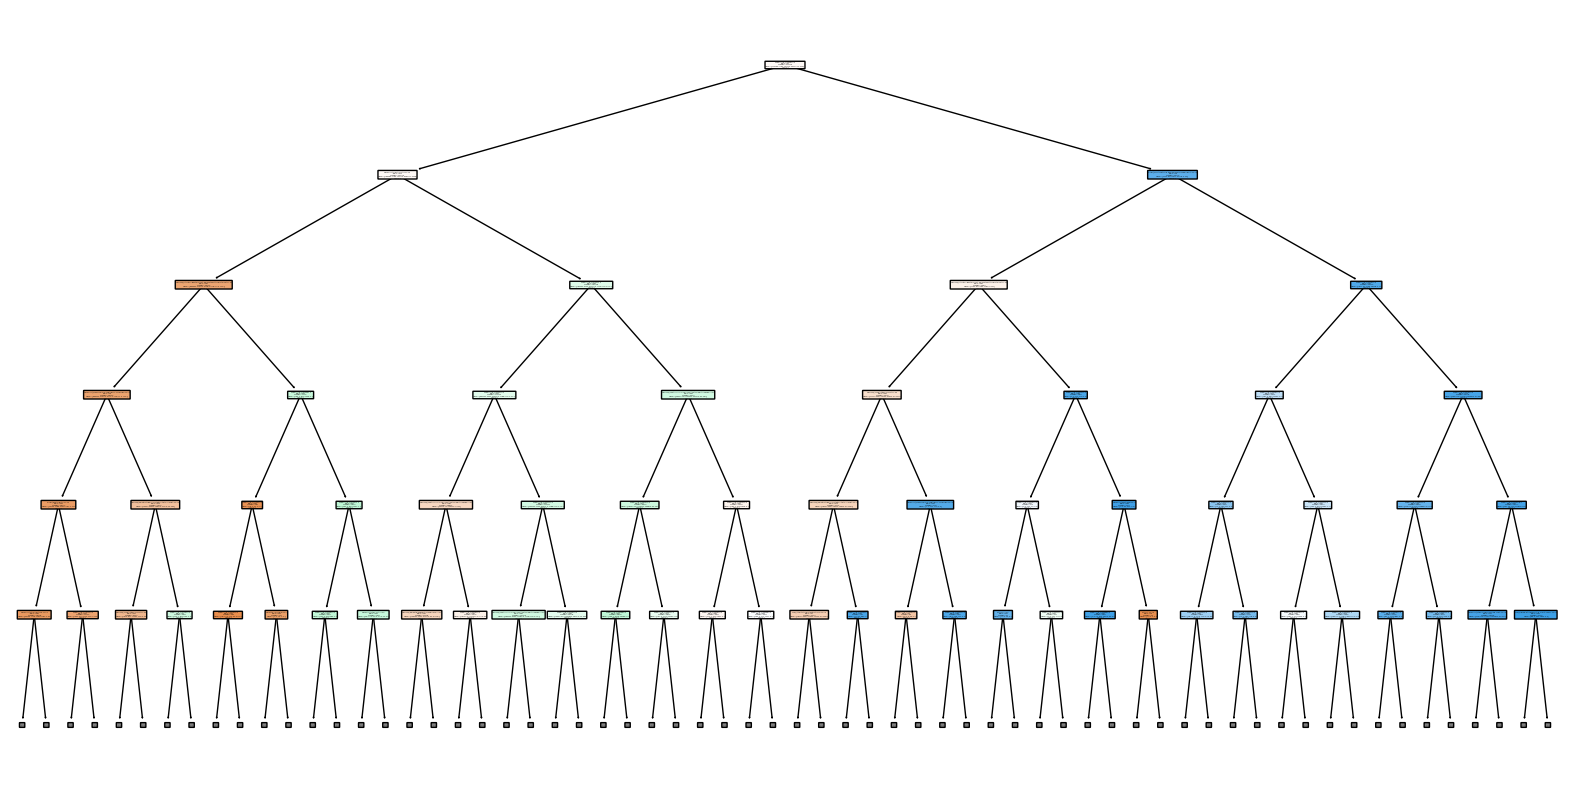

In [34]:
#Feature importance
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': dt_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

#Visualize the decision tree (optional)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=list(selected_features), class_names=list(map(str, dt_model.classes_)), filled=True, rounded=True, max_depth=5)
plt.show()